**Brian Blaylock**  
**January 14, 2019**

# Subset HDF5 Files for USMART -- OSG Climatology

In [1]:
import xarray
from datetime import datetime, timedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import hrrr_subset, get_hrrr_latlon, pluck_hrrr_point, get_hrrr_variable
from BB_maps.my_basemap import draw_centermap
from BB_cmap.NWS_standard_cmap import *
from BB_cmap.landuse_colormap import LU_MODIS21

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Geospatial Info:
1. Import the HRRR grid latitude and longitude.
2. Specify details about the CAMP fire.
3. Grab the indexes for the area of interest.
4. Get the HRRR land use categories

In [2]:
H_ll = get_hrrr_latlon()

In [3]:
location = {'CAMP': {'incident number': 'CA-BTU-016737',
                     'cause': 'Unknown',
                     'report date': datetime(2018, 11, 8),
                     'start date': datetime(2018, 11, 8),
                     'IMT Type': np.nan,
                     'state': 'California',
                     'area': np.nan,
                     'percent contained': 'Not Reported',
                     'expected containment': 'Not Reported',
                     'latitude': 39.820,
                     'longitude': -121.440,
                     'is MesoWest': False},
            'WOOLSEY': {'incident number': None,
                        'cause': 'Unknown',
                        'report date': datetime(2018, 11, 8),
                        'start date': datetime(2018, 11, 8),
                        'IMT Type': np.nan,
                        'state': 'California',
                        'area': np.nan,
                        'percent contained': 'Not Reported',
                        'expected containment': 'Not Reported',
                        'latitude': 34.235,
                        'longitude': -118.70128,
                        'is MesoWest': False}}

In [5]:
fire = 'CAMP'
lat = location[fire]['latitude']
lon = location[fire]['longitude']

In [6]:
m = draw_centermap(lat, lon, size=(1.3,1.4))

In [7]:
# The index for the nearest gridpoint to the fire
x, y = pluck_hrrr_point(H_ll,lat=lat, lon=lon, verbose=True, XY_only=True)

 >> Requested Center lat: 39.82	 lon: -121.44
 >>     Plucked HRRR lat: 39.81405	 lon: -121.44225
 >>     Plucked from   x: 666	   y: 225


In [8]:
# bbox is the number of grid points left/right/top/down to grab.
# For HRRR, the approx width of the box is bbox*2*3
half_box = 30
print('Approx Subset Box Size: %sx%s km' % (half_box*6, half_box*6))

box = [slice(x-half_box, x+half_box), slice(y-half_box, y+half_box)]

Approx Subset Box Size: 180x180 km


In [9]:
H_veg = get_hrrr_variable(datetime(2019,1,1), 'VGTYP:surface')
H_ter = get_hrrr_variable(datetime(2019,1,1), 'HGT:surface')


 >> Dowloading tempfile: ./temp_hrrr_2019010100_f00_VGT.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2.idx
 >> Matched a variable:  93:54858132:d=2019010100:VGTYP:surface:anl:
 >> Byte Range: 54858132 55639701
  Run Date: 2019-01-01 00:00 UTC F00
Valid Date: 2019-01-01 00:00 UTC

 >> Dowloading tempfile: ./temp_hrrr_2019010100_f00_HGT.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2.idx
 >> Matched a variable:  58:30896245:d=2019010100:HGT:surface:anl:
 >> Byte Range: 30896245 33131021
  Run Date: 2019-01-01 00:00 UTC F00
Valid Date: 2019-01-01 00:00 UTC


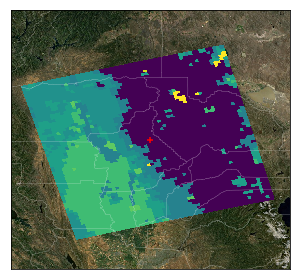

In [10]:
plt.figure(figsize=(5,5))
m.pcolormesh(H_ll['lon'][box], H_ll['lat'][box], H_veg['value'][box], latlon=True)
m.scatter(lon, lat, color='r', marker='+')
m.arcgisimage(xpixels=1000) 
m.drawcoastlines()
m.drawcounties(color='w')

### Subset the OSG data for this box

In [11]:
'''
plt.figure(figsize=(5,5))
m.pcolormesh(H_ll['lon'][box], H_ll['lat'][box], OSG.p05.data[box], latlon=True)
m.scatter(lon, lat, color='r', marker='+')
m.arcgisimage(xpixels=1000) 
m.drawcoastlines()
m.drawcounties(color='w')
'''

"\nplt.figure(figsize=(5,5))\nm.pcolormesh(H_ll['lon'][box], H_ll['lat'][box], OSG.p05.data[box], latlon=True)\nm.scatter(lon, lat, color='r', marker='+')\nm.arcgisimage(xpixels=1000) \nm.drawcoastlines()\nm.drawcounties(color='w')\n"

In [12]:
# Static Data
f = h5py.File('./data/OSG_CAMP_100km/HRRR_static.h5', 'w')
f.create_dataset('latitude', data=H_ll['lat'][box], compression="gzip", compression_opts=9)
f.create_dataset('longitude', data=H_ll['lon'][box], compression="gzip", compression_opts=9)
f.create_dataset('landuse', data=H_veg['value'][box], compression="gzip", compression_opts=9)
f.create_dataset('terrain', data=H_ter['value'][box], compression="gzip", compression_opts=9)
f.close()

In [23]:
# Write Percentile Datasets
percentiles = [0, 1, 5, 10, 25, 33, 50, 66, 75, 90, 95, 99, 100]

# Variables 
variables = ['TMP:2 m', 'UVGRD:10 m', 'UVGRD:80 m', 'GUST:surface', 'DPT:2 m']

# Every hour of the 15th day of each month
sDATE = datetime(2016, 1, 1)
eDATE = datetime(2017, 1, 1)
hours = (eDATE-sDATE).days*24
DATES = [sDATE+timedelta(hours=h) for h in range(hours) if (sDATE+timedelta(hours=h)).day==15]



# For each date, write a file with keys for each percentile value
for DATE in DATES:
    # Create a file for the month, day, hour (m##_d##_h##)
    f = h5py.File('./data/OSG_CAMP_100km/OSG_HRRR_%s_f00.h5' % (DATE.strftime('m%m_d%d_h%H')), 'w')
    f.create_dataset('DATE', data=DATE.strftime('%b %d, %H:%M UTC'))

    for v in variables:
        try:
            VAR = v.replace(':', '_').replace(' ', '_')
            DIR = '/uufs/chpc.utah.edu/common/home/horel-group8/blaylock/HRRR_OSG/hourly30/%s/' % VAR
            FILE = 'OSG_HRRR_%s_%s_f00.h5' % (VAR, DATE.strftime('m%m_d%d_h%H'))
            d = xarray.open_dataset(DIR+FILE)
            for PP in percentiles:
                try:
                    f.create_dataset('%s_p%02d' % (VAR, PP), data=d['p%02d' % PP].data[box],
                                     compression="gzip", compression_opts=9)
                except:
                    print('Could not do this variable: %s %s. Percentile: %s' % (v, DATE, PP))
            d.close()
        except:
            print('Could not do this variable: %s %s' % (v, DATE))

    f.close()

In [24]:
n = xarray.open_dataset('./data/OSG_CAMP_100km/OSG_HRRR_m01_d15_h00_f00.h5')
s = xarray.open_dataset('./data/OSG_CAMP_100km/HRRR_static.h5')

In [25]:
n

<xarray.Dataset>
Dimensions:            (phony_dim_0: 60)
Dimensions without coordinates: phony_dim_0
Data variables:
    DATE               object ...
    DPT_2_m_p00        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p01        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p05        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p10        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p100       (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p25        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p33        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p50        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p66        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p75        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p90        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p95        (phony_dim_0, phony_dim_0) float64 ...
    DPT_2_m_p99        (phony_dim_0, phony_dim_0) float64 ...
    GUST_surface_p00   (phony_dim_0, phony

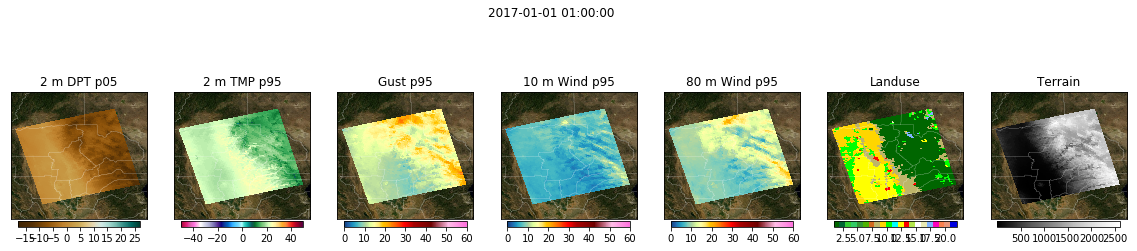

In [161]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(20,4))

plt.suptitle(DATE)

plt.sca(ax1)
plt.title('2 m DPT p05')
c = cm_dpt()
m.pcolormesh(s.longitude, s.latitude, n.DPT_2_m_p05-273.15, latlon=True,
             vmax=c['vmax'], vmin=c['vmin'], cmap=c['cmap'])
plt.colorbar(shrink=.9, pad=.01, orientation='horizontal')
m.arcgisimage()
m.drawcounties(color='w')

plt.sca(ax2)
plt.title('2 m TMP p95')
c = cm_temp()
m.pcolormesh(s.longitude, s.latitude, n.TMP_2_m_p95-273.15, latlon=True,
             vmax=c['vmax'], vmin=c['vmin'], cmap=c['cmap'])
plt.colorbar(shrink=.9, pad=.01, orientation='horizontal')
m.arcgisimage()
m.drawcounties(color='w')

plt.sca(ax3)
plt.title('Gust p95')
c = cm_wind()
m.pcolormesh(s.longitude, s.latitude, n.GUST_surface_p95, latlon=True,
             vmax=c['vmax'], vmin=c['vmin'], cmap=c['cmap'])
plt.colorbar(shrink=.9, pad=.01, orientation='horizontal')
m.arcgisimage()
m.drawcounties(color='w')

plt.sca(ax4)
plt.title('10 m Wind p95')
c = cm_wind()
m.pcolormesh(s.longitude, s.latitude, n.UVGRD_10_m_p95, latlon=True,
             vmax=c['vmax'], vmin=c['vmin'], cmap=c['cmap'])
plt.colorbar(shrink=.9, pad=.01, orientation='horizontal')
m.arcgisimage()
m.drawcounties(color='w')

plt.sca(ax5)
plt.title('80 m Wind p95')
c = cm_wind()
m.pcolormesh(s.longitude, s.latitude, n.UVGRD_80_m_p95, latlon=True,
             vmax=c['vmax'], vmin=c['vmin'], cmap=c['cmap'])
plt.colorbar(shrink=.9, pad=.01, orientation='horizontal')
m.arcgisimage()
m.drawcounties(color='w')

plt.sca(ax6)
plt.title('Landuse')
c = LU_MODIS21()
m.pcolormesh(s.longitude, s.latitude, s.landuse, latlon=True,
             cmap=c['cmap'], vmax=c['vmax'], vmin=c['vmin'])
plt.colorbar(shrink=.9, pad=.01, orientation='horizontal')
m.arcgisimage()
m.drawcounties(color='w')

plt.sca(ax7)
plt.title('Terrain')
m.pcolormesh(s.longitude, s.latitude, s.terrain, latlon=True, cmap='Greys_r')
plt.colorbar(shrink=.9, pad=.01, orientation='horizontal')
m.arcgisimage()
m.drawcounties(color='w')

In [ ]:
s.close()
n.close()